## Imports and Helper Functions

In [30]:
import torch
import torchvision
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False, normalized=False):
    if one_channel:
        img = img.mean(dim=0)
    if normalized:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

#list full file paths from a directory
def list_file_paths(dirs):
    all_files_paths = []
    for dir in dirs:
        files = os.listdir(dir)
        files_path = [os.path.join(dir, f) for f in files]
        all_files_paths += files_path

    return sorted(all_files_paths)

def train_val_split(frac_train, image_paths):
    image_paths = np.array(image_paths)
    n_images = len(image_paths)
        

# Dataset

In [32]:
class CoreSlices (torch.utils.data.Dataset):
    def __init__(self, imgs, transform):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):

        img = self.transform(Image.open(self.imgs[idx]))

        #get the root name of the file (no file extension) and extract the label
        label = os.path.splitext(os.path.basename(self.imgs[idx]))[0].split("_")[-1]
        
        return img, label



In [33]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #normalise
    #augmentation
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #normalise
])

#get list of all images in directories
image_dirs = ["data/slices/"]#,"data/Core Images/21-20a- 1/","data/Core Images/42-29- 6/","data/Core Images/206-01- 2/"]

images = list_file_paths(image_dirs)

images_train, images_val = train_test_split(images, train_size=0.8)
images_val, images_test = train_test_split(images_val, train_size=0.5)

slices = {}
slices["train"] = CoreSlices(images_train, train_transform)
slices["val"] = CoreSlices(images_train, train_transform)
slices["test"] = CoreSlices(images_train, test_transform)



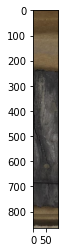

In [34]:
matplotlib_imshow(slices["train"][0][0])